In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
import sklearn
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm
import utils
import seaborn as sns
from IPython import display



2023-11-25 22:37:55.999191: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 22:37:56.042303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 22:37:56.042330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 22:37:56.043666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:37:56.051016: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 22:37:56.051579: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Import data 
game_state_20, game_state_40, game_state_60, game_state_80, game_state_100 = utils.get_inputs()


selected_dataset = game_state_40

selected_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
blueChampionKill,64556.0,7.991883,4.708893,0.0,5.00,8.0,11.0,36.0
blueFirstBlood,64556.0,0.483146,0.499720,0.0,0.00,0.0,1.0,1.0
blueDragonKill,64556.0,0.437310,0.567677,0.0,0.00,0.0,1.0,3.0
blueDragonElderKill,64556.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0
blueRiftHeraldKill,64556.0,0.299430,0.473641,0.0,0.00,0.0,1.0,2.0
blueBaronKill,64556.0,0.000031,0.005566,0.0,0.00,0.0,0.0,1.0
blueTowerKill,64556.0,0.249737,0.651966,0.0,0.00,0.0,0.0,8.0
blueInhibitorKill,64556.0,0.000139,0.011807,0.0,0.00,0.0,0.0,1.0
blueTotalGold,64556.0,18391.697766,6621.723784,2500.0,14647.75,18615.0,22534.0,52641.0
blueMinionsKilled,64556.0,210.583168,82.662109,0.0,166.00,217.0,264.0,544.0


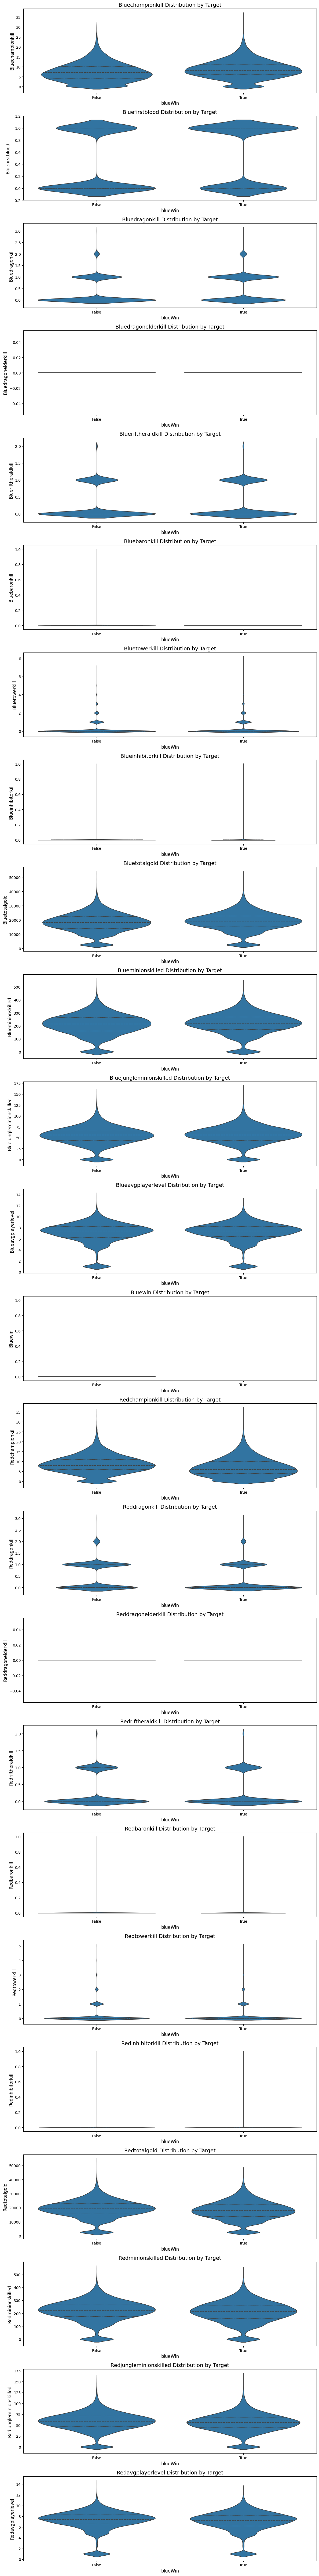

In [3]:
# Visualize data

cont_cols = [f for f in selected_dataset.columns if selected_dataset[f].dtype != '0']
n_rows = len(cont_cols)

fig, axs = plt.subplots(n_rows, 1, figsize=(12, 4 * n_rows))

for i, col in enumerate(cont_cols):
    sns.violinplot(x='blueWin', y=col, data=selected_dataset, ax=axs[i], inner="quart", bw_adjust = 1.1)
    axs[i].set_title(f'{col.title()} Distribution by Target', fontsize=14)
    axs[i].set_xlabel('blueWin', fontsize=12)
    axs[i].set_ylabel(col.title(), fontsize=12)
    #sns.despine()

fig.tight_layout()

plt.show()

In [4]:
# Prepare training, validation, and test datasets for 20% game time


train_frac = 0.8
valid_frac = 0.1

train_set = selected_dataset.sample(frac = 0.8)
remaining_set = selected_dataset.drop(train_set.index)
valid_set = selected_dataset.sample(frac = valid_frac / (1 - train_frac))
test_set = selected_dataset.drop(valid_set.index)

# Separate wins
train_wins = train_set.pop('blueWin')
valid_wins = valid_set.pop('blueWin')
test_wins = test_set.pop('blueWin')

print(selected_dataset.shape, train_set.shape, valid_set.shape, test_set.shape)


(64556, 24) (51645, 23) (32278, 23) (32278, 23)


In [56]:
# Feature engineering

In [5]:
# Convert dataframes to tensors
train_data = tf.convert_to_tensor(train_set)
train_labels = tf.convert_to_tensor(train_wins)

valid_data = tf.convert_to_tensor(valid_set)
valid_labels = tf.convert_to_tensor(valid_wins)

#train_data = train_data[..., tf.newaxis]
#valid_data = valid_data[..., tf.newaxis]
# Define batches

def get_batch(data, labels, batch_size):
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(batch_size)

train_batched = get_batch(train_data, train_labels, 64)
valid_batched = get_batch(valid_data, valid_labels, 64)

print(tf.shape(train_data), tf.shape(train_labels))


tf.Tensor([51645    23], shape=(2,), dtype=int32) tf.Tensor([51645], shape=(1,), dtype=int32)


In [14]:
# Define model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(23,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Choose optimizer and loss function
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)
loss_func = tf.keras.losses.BinaryCrossentropy()

# Compile and train model
model.compile(optimizer=optimizer, loss = loss_func, metrics=['accuracy'])
model.fit(train_data, train_labels, epochs = 10, batch_size=64)

# Test model
model.evaluate(valid_data, valid_labels)

Epoch 1/10
807/807 [==============================] - 5s 5ms/step - loss: 60.8965 - accuracy: 0.5876
Epoch 2/10
807/807 [==============================] - 4s 5ms/step - loss: 12.7796 - accuracy: 0.5918
Epoch 3/10
807/807 [==============================] - 5s 6ms/step - loss: 5.4496 - accuracy: 0.5879
Epoch 4/10
807/807 [==============================] - 4s 5ms/step - loss: 2.0855 - accuracy: 0.5989
Epoch 5/10
807/807 [==============================] - 5s 6ms/step - loss: 1.3653 - accuracy: 0.6014
Epoch 6/10
807/807 [==============================] - 4s 5ms/step - loss: 0.9712 - accuracy: 0.6121
Epoch 7/10
807/807 [==============================] - 4s 5ms/step - loss: 0.7406 - accuracy: 0.6324
Epoch 8/10
807/807 [==============================] - 4s 5ms/step - loss: 0.7039 - accuracy: 0.6436
Epoch 9/10
807/807 [==============================] - 5s 6ms/step - loss: 0.6750 - accuracy: 0.6505
Epoch 10/10
1009/1009 [==============================] - 2s 2ms/step - loss: 0.6355 - accuracy: 0.

[0.6355421543121338, 0.6830968260765076]

In [ ]:
# Test manual train for visualization
# Define training step
@tf.function
def train_step(match_states, outcomes):
    with tf.GradientTape() as tape:  
        predictions = tf.squeeze(model.call(match_states))
        loss = loss_func(outcomes, predictions)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(outcomes, predictions)


# Define testing step
@tf.function
def test_step(match_states, outcomes):
    predictions = tf.squeeze(model.call(match_states))
    loss = loss_func(outcomes, predictions)

    valid_loss(loss)
    valid_accuracy(outcomes, predictions)

# Plots
loss_plot, loss_ax = plt.subplots()
loss_ax.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
dh = display.display(loss_plot, display_id=True)

# Run
EPOCHS = 100

x_plot, y_plot = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss.reset_states()

    for match_states, outcomes in train_batched:
        train_step(match_states, outcomes)

    
    x_plot.append(epoch)
    y_plot.append(train_loss.result().numpy())
    loss_ax.plot(x_plot, y_plot, color='blue')
    dh.update(loss_plot)
    time.sleep(0.1)

    
    if epoch % 10 == 0:
        model.save_weights(output_prefix)
        
plt.close()

for match_states, outcomes in valid_batched:
    test_step(match_states, outcomes)

print(f'Loss: {train_loss.result()}, 'f'Accuracy: {train_accuracy.result()}, 'f'Validation Loss: {valid_loss.result()}, 'f'Validation Accuracy: {valid_accuracy.result()}')
# Set output
output_dir = './output'
output_prefix = os.path.join(output_dir, "DNN_2l_20")

model.save_weights(output_prefix)